# Initialize Spark

In [27]:
# Create a Spark Session
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

In [28]:
spark = SparkSession.builder.master("spark://spark-master:7077").appName("stock_price_analysis").getOrCreate()

In [29]:
spark.version

'3.3.0'

In [30]:
spark.sparkContext._jsc.sc().isStopped()

False

In [67]:
!pip install scikit-learn

  Using cached scikit_learn-1.7.2-cp310-cp310-manylinux_2_27_aarch64.manylinux_2_28_aarch64.whl (9.5 MB)
  Using cached scipy-1.15.3-cp310-cp310-manylinux_2_17_aarch64.manylinux2014_aarch64.whl (35.5 MB)


In [31]:
!pip install matplotlib

In [32]:
!pip install pandas

In [33]:
!pip install tensorflow

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path
from os import path
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Vietnam's Stock Analysis

Analyze Vietnam's top 5 most dominating stock on the stock market. This is a mix of major banking institutions, real estate conglomerates, and industrial powerhouses.

In [35]:
df_VIC = spark.read.format("csv").option("header", "true")\
.option("inferSchema", "true").load("hdfs://namenode:9000/data/data/stock_data_VIC.csv")

df_VHM = spark.read.format("csv").option("header", "true")\
.option("inferSchema", "true").load("hdfs://namenode:9000/data/data/stock_data_VHM.csv")

df_BID = spark.read.format("csv").option("header", "true")\
.option("inferSchema", "true").load("hdfs://namenode:9000/data/data/stock_data_BID.csv")

df_VPB = spark.read.format("csv").option("header", "true")\
.option("inferSchema", "true").load("hdfs://namenode:9000/data/data/stock_data_VPB.csv")

df_HPG = spark.read.format("csv").option("header", "true")\
.option("inferSchema", "true").load("hdfs://namenode:9000/data/data/stock_data_HPG.csv")

## 1. Stock daily mean price

In [36]:
# Get the mean price of each stock
from pyspark.sql.functions import year, expr

df_VIC_mean = df_VIC.withColumn("Mean", expr('(High+Low)/2'))
df_VHM_mean = df_VHM.withColumn("Mean", expr('(High+Low)/2'))
df_BID_mean = df_BID.withColumn("Mean", expr('(High+Low)/2'))
df_VPB_mean = df_VPB.withColumn("Mean", expr('(High+Low)/2'))
df_HPG_mean = df_HPG.withColumn("Mean", expr('(High+Low)/2'))

In [37]:
df_VIC_mean.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: integer (nullable = true)
 |-- Mean: double (nullable = true)



In [38]:
# Convert to pandas DataFrame
from pyspark.sql.functions import col

df_VIC_mean = df_VIC_mean.withColumn("time", col("time").cast("string")).toPandas()
df_VIC_mean['time'] = pd.to_datetime(df_VIC_mean['time'])

df_VHM_mean = df_VHM_mean.withColumn("time", col("time").cast("string")).toPandas()
df_VHM_mean['time'] = pd.to_datetime(df_VHM_mean['time'])

df_BID_mean = df_BID_mean.withColumn("time", col("time").cast("string")).toPandas()
df_BID_mean['time'] = pd.to_datetime(df_BID_mean['time'])

df_VPB_mean = df_VPB_mean.withColumn("time", col("time").cast("string")).toPandas()
df_VPB_mean['time'] = pd.to_datetime(df_VPB_mean['time'])

df_HPG_mean = df_HPG_mean.withColumn("time", col("time").cast("string")).toPandas()
df_HPG_mean['time'] = pd.to_datetime(df_HPG_mean['time'])

In [39]:
df_VIC_mean

,_c0,time,open,high,low,close,volume,Mean
0,0,2012-01-03,16.51,16.85,16.43,16.43,39190,16.640
1,1,2012-01-04,16.60,16.68,16.43,16.51,38760,16.555
2,2,2012-01-05,16.43,16.43,15.76,15.76,15860,16.095
3,3,2012-01-06,15.76,15.76,15.60,15.68,22080,15.680
4,4,2012-01-09,15.68,16.43,15.51,16.43,14940,15.970
...,...,...,...,...,...,...,...,...
3436,3436,2025-10-10,178.50,192.00,178.50,192.00,4294700,185.250
3437,3437,2025-10-13,193.90,205.40,193.90,205.40,7178300,199.650
3438,3438,2025-10-14,215.90,219.70,206.90,211.90,8065500,213.300
3439,3439,2025-10-15,214.10,214.90,206.00,209.50,3752400,210.450


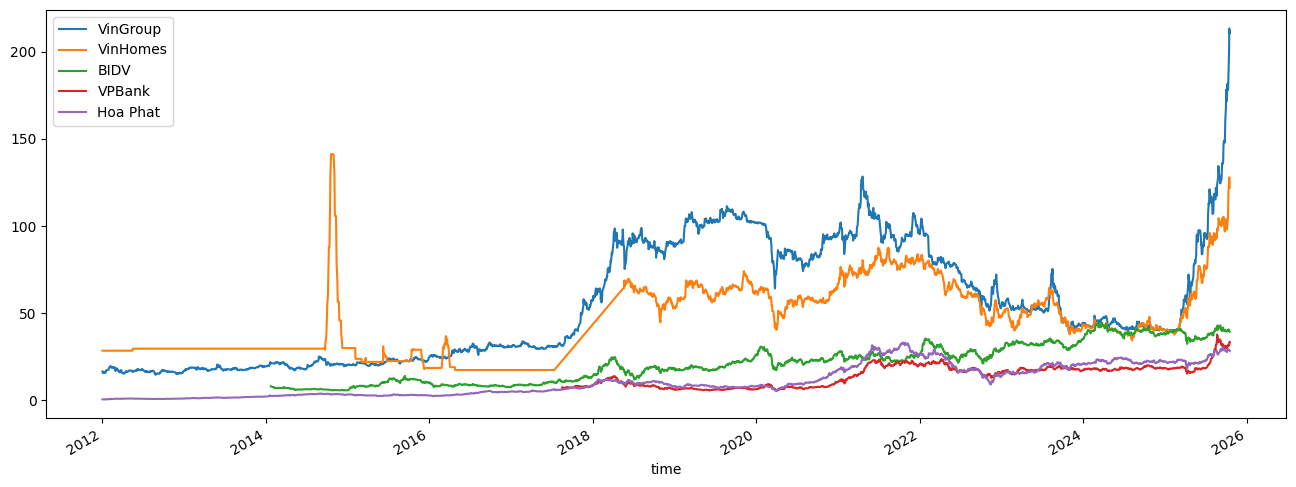

In [40]:
ax = df_VIC_mean.plot(x='time', y='Mean', label='VinGroup', figsize=(16, 6))
ax = df_VHM_mean.plot(ax=ax, x='time', y='Mean', label='VinHomes')
ax = df_BID_mean.plot(ax=ax, x='time', y='Mean', label='BIDV')
ax = df_VPB_mean.plot(ax=ax, x='time', y='Mean', label='VPBank')
ax = df_HPG_mean.plot(ax=ax, x='time', y='Mean', label='Hoa Phat')

## 2. Get the daily return of each stock

In [41]:
df_VIC_mean['daily_return'] = df_VIC_mean['close'].pct_change()
df_VHM_mean['daily_return'] = df_VHM_mean['close'].pct_change()
df_BID_mean['daily_return'] = df_BID_mean['close'].pct_change()
df_VPB_mean['daily_return'] = df_VPB_mean['close'].pct_change()
df_HPG_mean['daily_return'] = df_HPG_mean['close'].pct_change()

In [42]:
df_VIC_mean.head(5)

,_c0,time,open,high,low,close,volume,Mean,daily_return
0,0,2012-01-03,16.51,16.85,16.43,16.43,39190,16.640,NaN
1,1,2012-01-04,16.60,16.68,16.43,16.51,38760,16.555,0.004869
2,2,2012-01-05,16.43,16.43,15.76,15.76,15860,16.095,-0.045427
3,3,2012-01-06,15.76,15.76,15.60,15.68,22080,15.680,-0.005076
4,4,2012-01-09,15.68,16.43,15.51,16.43,14940,15.970,0.047832


In [43]:
volatility_VIC = df_VIC_mean['daily_return'].std()
volatility_VHM = df_VHM_mean['daily_return'].std()
volatility_BID = df_BID_mean['daily_return'].std()
volatility_VPB = df_VPB_mean['daily_return'].std()
volatility_HPG = df_HPG_mean['daily_return'].std()

In [44]:
print(f"VIC Volatility: {volatility_VIC:.4f}")
print(f"VHM Volatility: {volatility_VHM:.4f}")
print(f"BID Volatility: {volatility_BID:.4f}")
print(f"VPB Volatility: {volatility_VPB:.4f}")
print(f"HPG Volatility: {volatility_HPG:.4f}")

VIC Volatility: 0.0188
VHM Volatility: 0.0524
BID Volatility: 0.0217
VPB Volatility: 0.0221
HPG Volatility: 0.0212


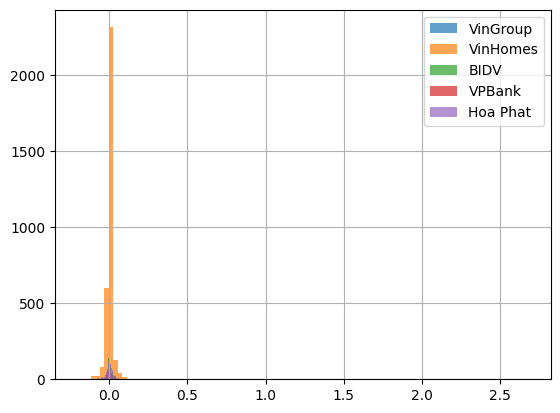

In [45]:
import matplotlib.pyplot as plt

df_VIC_mean['daily_return'].hist(bins=100, label='VinGroup',alpha=0.7)
df_VHM_mean['daily_return'].hist(bins=100, label='VinHomes',alpha=0.7)
df_BID_mean['daily_return'].hist(bins=100, label='BIDV',alpha=0.7)
df_VPB_mean['daily_return'].hist(bins=100, label='VPBank',alpha=0.7)
df_HPG_mean['daily_return'].hist(bins=100, label='Hoa Phat',alpha=0.7)
plt.legend()

## 3. Correlation matrix for daily returns

In [46]:
df_VIC_ret = df_VIC_mean.set_index('time')['daily_return'].rename('VIC')
df_VHM_ret = df_VHM_mean.set_index('time')['daily_return'].rename('VHM')
df_BID_ret = df_BID_mean.set_index('time')['daily_return'].rename('BID')
df_VPB_ret = df_VPB_mean.set_index('time')['daily_return'].rename('VPB')
df_HPG_ret = df_HPG_mean.set_index('time')['daily_return'].rename('HPG')

In [47]:
df_VIC_ret

time
2012-01-03         NaN
2012-01-04    0.004869
2012-01-05   -0.045427
2012-01-06   -0.005076
2012-01-09    0.047832
                ...   
2025-10-10    0.069638
2025-10-13    0.069792
2025-10-14    0.031646
2025-10-15   -0.011326
2025-10-16    0.017184
Name: VIC, Length: 3441, dtype: float64

In [48]:
import pandas as pd

all_returns = pd.concat([df_VIC_ret, df_VHM_ret, df_BID_ret, df_VPB_ret, df_HPG_ret], axis=1)

In [49]:
# Drop all NaN values
all_returns_common = all_returns.dropna()

In [50]:
# Print out correlation matrix
correlation_matrix = all_returns.corr()
print(correlation_matrix)

          VIC       VHM       BID       VPB       HPG
VIC  1.000000  0.083734  0.235315  0.240749  0.274639
VHM  0.083734  1.000000  0.070000  0.047953  0.071546
BID  0.235315  0.070000  1.000000  0.560841  0.420307
VPB  0.240749  0.047953  0.560841  1.000000  0.492106
HPG  0.274639  0.071546  0.420307  0.492106  1.000000


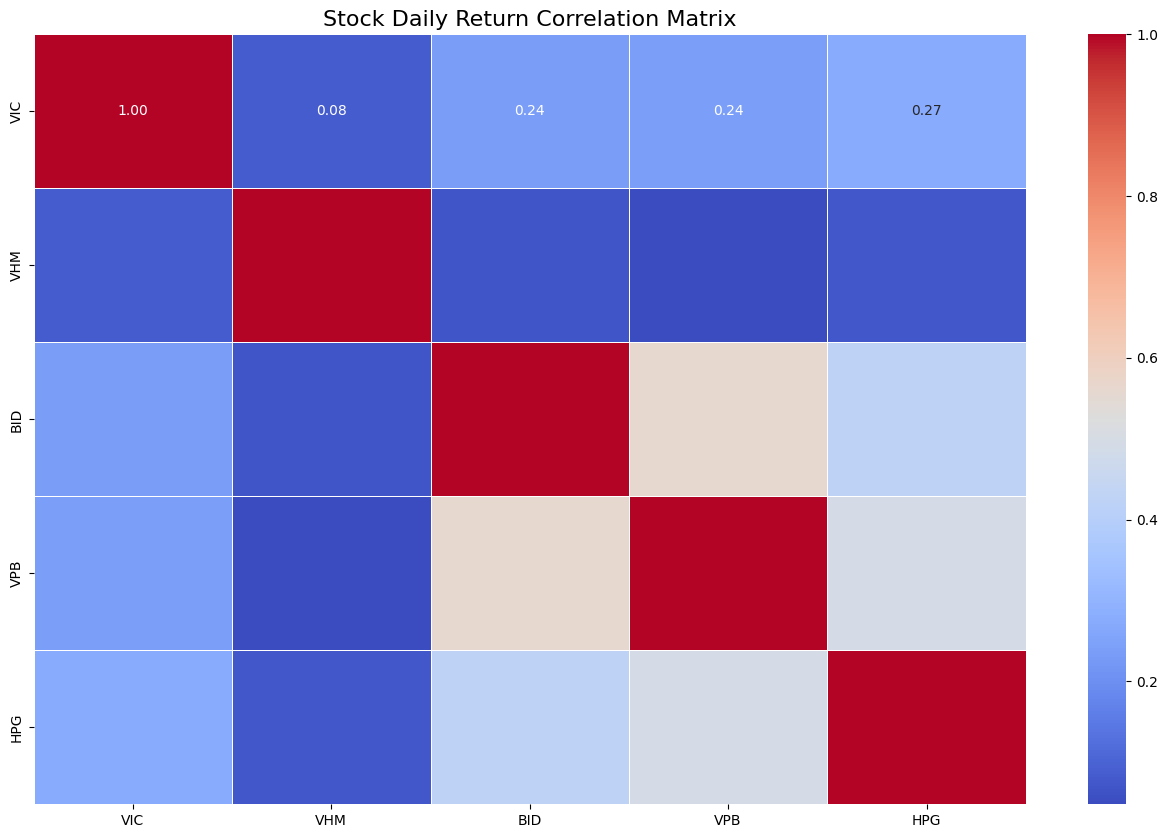

In [51]:
import seaborn as sns

plt.figure(figsize=(16, 10))

sns.heatmap(
    correlation_matrix,  
    annot=True,          
    cmap='coolwarm',     
    fmt='.2f',           
    linewidths=0.5       
)

plt.title('Stock Daily Return Correlation Matrix', fontsize=16)
plt.show()

## 5. Stock price prediction using Machine Learning

We use a Machine Learning model to predict the mean price value for Vinamilk's stock (VNM) in 2024. Training data will be Vinamilk's stock data before 2024.

In [52]:
vnm_df = spark.read.format("csv").option("header", "true")\
.option("inferSchema", "true").load("hdfs://namenode:9000/data/data/stock_data_VNM.csv")

In [53]:
vnm_df.show(5)

+---+-------------------+-----+-----+-----+-----+------+
|_c0|               time| open| high|  low|close|volume|
+---+-------------------+-----+-----+-----+-----+------+
|  0|2012-01-03 00:00:00|12.42| 12.5| 12.2|12.35|122220|
|  1|2012-01-04 00:00:00| 12.2| 12.2|12.06|12.06|113820|
|  2|2012-01-05 00:00:00|11.77|11.84|11.55|11.62|157620|
|  3|2012-01-06 00:00:00| 11.4|11.98| 11.4|11.77| 81310|
|  4|2012-01-09 00:00:00|11.77|11.84|11.62|11.84| 28260|
+---+-------------------+-----+-----+-----+-----+------+
only showing top 5 rows



In [54]:
from pyspark.sql.functions import expr, col, column
vnm_df = vnm_df.withColumn("Mean", expr('(High+Low)/2'))

In [55]:
vnm_df.show(5)

+---+-------------------+-----+-----+-----+-----+------+------------------+
|_c0|               time| open| high|  low|close|volume|              Mean|
+---+-------------------+-----+-----+-----+-----+------+------------------+
|  0|2012-01-03 00:00:00|12.42| 12.5| 12.2|12.35|122220|             12.35|
|  1|2012-01-04 00:00:00| 12.2| 12.2|12.06|12.06|113820|12.129999999999999|
|  2|2012-01-05 00:00:00|11.77|11.84|11.55|11.62|157620|            11.695|
|  3|2012-01-06 00:00:00| 11.4|11.98| 11.4|11.77| 81310|11.690000000000001|
|  4|2012-01-09 00:00:00|11.77|11.84|11.62|11.84| 28260|             11.73|
+---+-------------------+-----+-----+-----+-----+------+------------------+
only showing top 5 rows



In [56]:
# Sort according to time
vnm_df = vnm_df.sort(vnm_df.time.asc())

In [57]:
vnm_df.show(5)

+---+-------------------+-----+-----+-----+-----+------+------------------+
|_c0|               time| open| high|  low|close|volume|              Mean|
+---+-------------------+-----+-----+-----+-----+------+------------------+
|  0|2012-01-03 00:00:00|12.42| 12.5| 12.2|12.35|122220|             12.35|
|  1|2012-01-04 00:00:00| 12.2| 12.2|12.06|12.06|113820|12.129999999999999|
|  2|2012-01-05 00:00:00|11.77|11.84|11.55|11.62|157620|            11.695|
|  3|2012-01-06 00:00:00| 11.4|11.98| 11.4|11.77| 81310|11.690000000000001|
|  4|2012-01-09 00:00:00|11.77|11.84|11.62|11.84| 28260|             11.73|
+---+-------------------+-----+-----+-----+-----+------+------------------+
only showing top 5 rows



In [58]:
# Get test set
from pyspark.sql.functions import year
df_test = vnm_df.filter(year("time") > 2024)

In [59]:
df_test.show(5)

+----+-------------------+-----+-----+-----+-----+-------+------------------+
| _c0|               time| open| high|  low|close| volume|              Mean|
+----+-------------------+-----+-----+-----+-----+-------+------------------+
|3246|2025-01-02 00:00:00|58.67|58.86|58.21|58.21|1339894|            58.535|
|3247|2025-01-03 00:00:00| 58.3| 58.4|58.03|58.12|1779619|            58.215|
|3248|2025-01-06 00:00:00|58.12| 58.3|57.66|57.66|2108984|             57.98|
|3249|2025-01-07 00:00:00|57.75|58.12|56.83|56.92|2811099|57.474999999999994|
|3250|2025-01-08 00:00:00| 57.2|57.29|56.46|56.92|2057556|            56.875|
+----+-------------------+-----+-----+-----+-----+-------+------------------+
only showing top 5 rows



In [60]:
df_test.count()

195

In [61]:
# Get train set
df_train = vnm_df.subtract(df_test)
df_train.count()

3246

In [62]:
df_train.show(5)

+---+-------------------+-----+-----+-----+-----+------+------+
|_c0|               time| open| high|  low|close|volume|  Mean|
+---+-------------------+-----+-----+-----+-----+------+------+
| 15|2012-01-31 00:00:00| 12.5|12.72| 12.5|12.57| 65290| 12.61|
| 33|2012-02-24 00:00:00|13.45|13.52|13.37|13.37| 74330|13.445|
|185|2012-10-01 00:00:00|17.79|17.95|17.64|17.64|196700|17.795|
|593|2014-05-28 00:00:00|29.69|29.93|29.21|29.45|109830| 29.57|
|762|2015-01-26 00:00:00|29.16|29.45|29.01|29.01|115330| 29.23|
+---+-------------------+-----+-----+-----+-----+------+------+
only showing top 5 rows



In [63]:
# Sort train set
df_train = df_train.sort(df_train.time.asc())
df_train.show(5)

+---+-------------------+-----+-----+-----+-----+------+------------------+
|_c0|               time| open| high|  low|close|volume|              Mean|
+---+-------------------+-----+-----+-----+-----+------+------------------+
|  0|2012-01-03 00:00:00|12.42| 12.5| 12.2|12.35|122220|             12.35|
|  1|2012-01-04 00:00:00| 12.2| 12.2|12.06|12.06|113820|12.129999999999999|
|  2|2012-01-05 00:00:00|11.77|11.84|11.55|11.62|157620|            11.695|
|  3|2012-01-06 00:00:00| 11.4|11.98| 11.4|11.77| 81310|11.690000000000001|
|  4|2012-01-09 00:00:00|11.77|11.84|11.62|11.84| 28260|             11.73|
+---+-------------------+-----+-----+-----+-----+------+------------------+
only showing top 5 rows



In [65]:
train_set = df_train.withColumn("time", col("time").cast("string")).toPandas()
train_set['time'] = pd.to_datetime(train_set['time'])

test_set = df_test.withColumn("time", col("time").cast("string")).toPandas()
test_set['time'] = pd.to_datetime(test_set['time'])

In [68]:
from sklearn.preprocessing import MinMaxScaler

train_set = train_set[['Mean']]
scaler = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = scaler.fit_transform(train_set)

In [69]:
training_set_scaled

array([[7.31910175e-03],
       [4.87940116e-03],
       [5.54477405e-05],
       ...,
       [5.24092043e-01],
       [5.20044358e-01],
       [5.20543388e-01]])

In [70]:
X_train = []
y_train = []
no_of_sample = len(train_set)

for i in range(60, no_of_sample):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [80]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [81]:
real_stock_price = test_set[['Mean']]

In [86]:
if path.exists("mymodel.h5"):
    regressor.load_weights("mymodel.h5")
else:
    regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)
    regressor.save("mymodel.h5")

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - loss: 0.0177
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0040
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0037
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0033
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0033
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0030
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0028
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0028
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0024
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0024
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0025
Epoch 12/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0022
Epoch 13/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0021
Epoch 14/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0019
Epoch 15/100
100/100 ━━━━━━━━

In [89]:
# Prediction
dataset_total = pd.concat((train_set[['Mean']], test_set[['Mean']]), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test = []
no_of_sample = len(inputs)

for i in range(60, no_of_sample):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


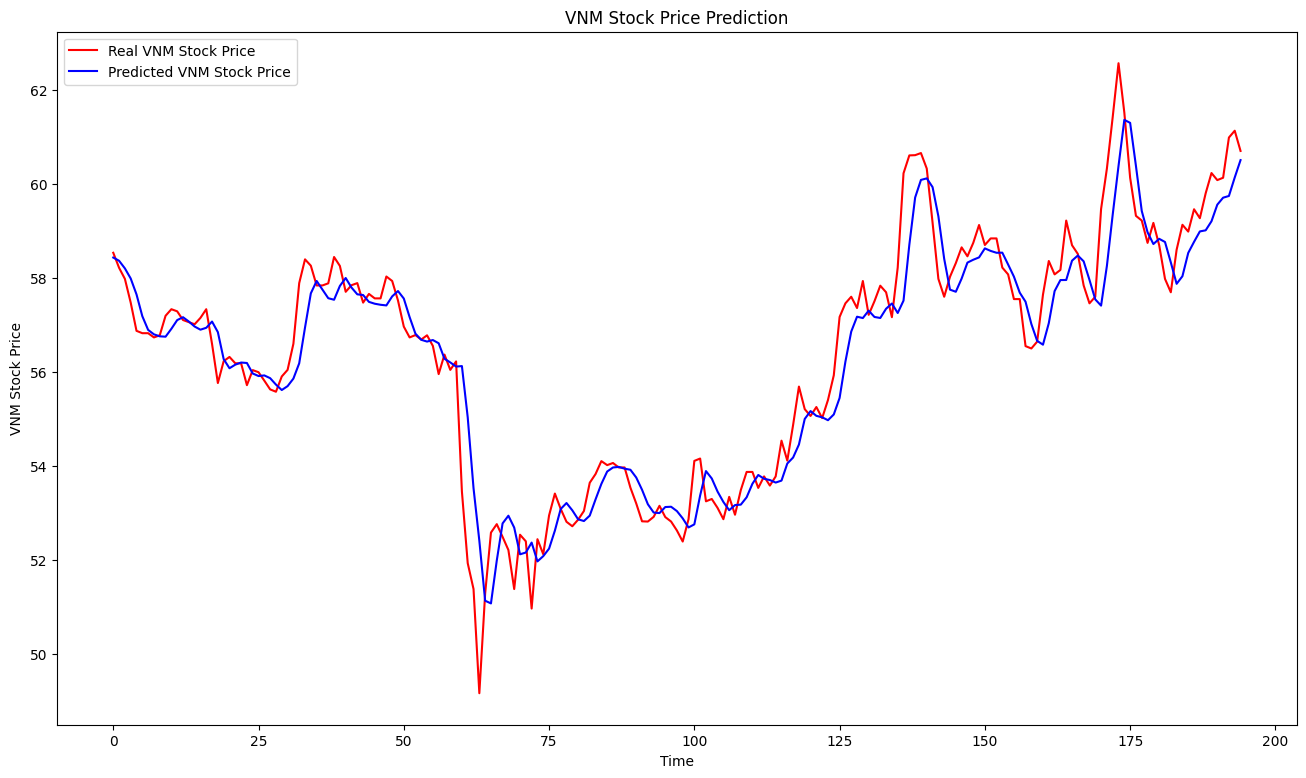

In [90]:
plt.figure(figsize=(16,9))

plt.plot(test_set['Mean'], color = 'red', label = 'Real VNM Stock Price') 
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted VNM Stock Price') 

plt.title('VNM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('VNM Stock Price')
plt.legend()
plt.show()

In [91]:
spark.stop()